In [215]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy


import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import xgboost
from mlxtend.regressor import StackingRegressor

np.random.seed(7)

In [163]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

# Recommended by the creator of the dataset.
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Save ID
train_ID = train['Id']
test_ID = test['Id']

X_train = train.drop(['Id','SalePrice'], axis = 1)
y_train = train.SalePrice

test = test.drop('Id',axis = 1)

## Feature engineering

In [164]:
def split(X_train,y_train): # split function

    X_train, X_test, y_train, y_test  = train_test_split(X_train,y_train)
    
    return X_train, X_test, y_train, y_test

### Categorical variables

Some of the columns that are numeric, are still categorical variables, so we have to change that. 

In [165]:
def to_cat(df):
    
    change = ['MSSubClass','OverallCond','YrSold','MoSold','YearBuilt','YearRemodAdd']
    for col in change: df[col] = df[col].apply(str)
    
    return df

In [166]:
X_train = to_cat(X_train)

### Missing values

The documentation mentioned that we had missing values, let's check them out. 

In [167]:
missing = X_train.isnull().sum() / len(X_train) # Let's get the missing values percentage for each column.
missing = missing.sort_values(ascending=False).to_frame('Missing percentage').reset_index() # Lets sort it.

In [168]:
missing.head(5) # Now let's see the 5 columns with more missing values.

,index,Missing percentage
0,PoolQC,0.995885
1,MiscFeature,0.962963
2,Alley,0.937586
3,Fence,0.807270
4,FireplaceQu,0.473251


We can see that we have some features with a lot of missing values, such as Pool, Misc Feature and Alley. We could drop them.   
However, the documentation states that no value means that there is no pool or misc feature or alley. So despite it being a small amount of information, it could still be valuable.

### Dependent variable

First, let's see our original column, saleprice. 

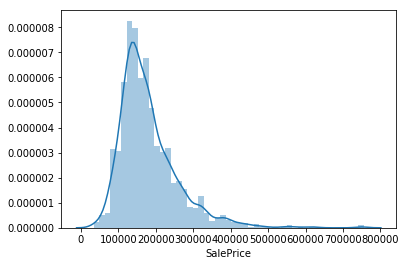

In [169]:
sns.distplot(y_train)
plt.show()

We can see that our data looks like a normal with a right skew.  In order to correct this, we will transform our values from SalePrice

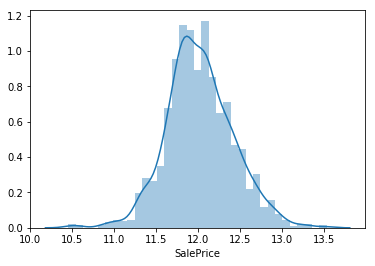

In [170]:
# np.log1p does log(1+x) to the SalePrice
y_train = np.log1p(y_train)
# Lets see how it looks
sns.distplot(y_train);
plt.show()

### Correlations

Let's see how our variables correlate with the dependent variable.

In [171]:
corrmat = X_train.corr()
# Lets order the correlation matrix in order for it to be more readable
order = np.array(hierarchy.dendrogram(
    hierarchy.ward(corrmat),no_plot=True)['ivl'], dtype="int")

In [172]:
corrmat_ordered = corrmat.iloc[order,order]

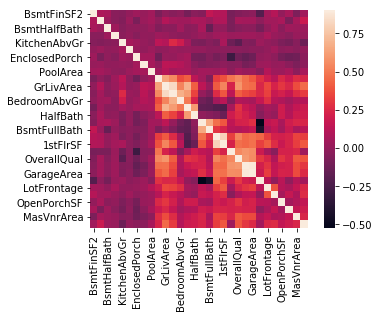

In [173]:
sns.heatmap(corrmat_ordered, vmax=0.9, square=True)
plt.show()

### Data imputation

Reading the data description, if the data is not there, you have to substitute for None (while categorical). 
Also, we will use 0 for the numerical, since it is more probable that they do not have the feature rather than them having the mean.

In [174]:
def imputation(df):
    
    categorical = df.dtypes == object
    
    # Lets do the data imputation
    preprocess = make_column_transformer(
        (SimpleImputer(missing_values=np.nan, strategy='constant',fill_value = 0), ~categorical),
        (SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='None'), categorical))
    
    df = pd.DataFrame(preprocess.fit_transform(df), columns =df.columns.values) # Make it a df again.
    
    return df

In [175]:
X_train = imputation(X_train)

In [176]:
def check_missing(df,val): 
    missing = df.isnull().sum() / len(df) # Let's get the missing values percentage for each column.
    missing = missing.sort_values(ascending=False).to_frame('Missing percentage').reset_index() # Lets sort it.
    remaining = missing[missing['Missing percentage'] > val]['index'].values
    return remaining

In [177]:
check_missing(X_train,0) # Now let's see if there are things that are left.

array([], dtype=object)

In [178]:
def preprocess_test(test):
    
    test = to_cat(test)
    test = imputation(test)
    # test = imputation2(test)
    if check_missing(test,0) != 0: return 'Something is wrong', check_missing(test,0)
    else: return test

In [179]:
test = preprocess_test(test)

Now that we know what our dataframe features are, and we have done some feature selection, we are going to start trying to predict.

## Baseline

Let's create a baseline for prediction. We will create a couple linear regresions and see what parameters are optimal. Once this is done, we will try to obtain a prediction and see how we did. 

In [180]:
def regression_w_GS(X_train,y_train):

    categorical = X_train.dtypes == object
    X_train, X_test, y_train, y_test = split(X_train,y_train)

    # Lets do the column transformer with Standar Scaler and One-Hot Encoder.
    preprocess = make_column_transformer(
        (RobustScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))

    model_LR = make_pipeline(preprocess, LinearRegression())
    model_R = make_pipeline(preprocess, Ridge())
    model_L = make_pipeline(preprocess, Lasso())
    model_EN = make_pipeline(preprocess, ElasticNet())

    # Linear Regression.

    param_grid_LR = {'linearregression__fit_intercept': (True,False),
                  'linearregression__normalize': (True,False)}

    grid_LR = GridSearchCV(model_LR,param_grid_LR,scoring="neg_mean_squared_error", cv=5, n_jobs = -1)
    
    #return X_train, y_train
    
    grid_LR.fit(X_train, y_train)

    print('\t\t\t Linear Regression: \n')
    print(grid_LR.best_params_, '\t score: ',np.sqrt(-grid_LR.score(X_test, y_test)),'\n')

    # Ridge.

    param_grid_R = {'ridge__alpha':np.logspace(-3, 3, num=13)} # we will check alphas between 0.001 and 100

    grid_R = GridSearchCV(model_R,param_grid_R,scoring="neg_mean_squared_error", cv=3, n_jobs = -1)
    grid_R.fit(X_train, y_train)

    print('\t\t\t Ridge: \n')
    print(grid_R.best_params_, '\t score: ',np.sqrt(-grid_R.score(X_test, y_test)),'\n')

    # Lasso.

    param_grid_L = {'lasso__alpha':np.logspace(-3, 3, num=13)} # we will check alphas between 0.001 and 100

    grid_L = GridSearchCV(model_L,param_grid_L,scoring="neg_mean_squared_error", cv=3, n_jobs = -1)
    grid_L.fit(X_train, y_train)

    print('\t\t\t Lasso: \n')
    print(grid_L.best_params_, '\t score: ',np.sqrt(-grid_L.score(X_test, y_test)),'\n')

    # ElasticNet.

    param_grid_EN = {'elasticnet__alpha':np.logspace(-4, 0, 13)}

    grid_EN = GridSearchCV(model_EN,param_grid_EN,scoring="neg_mean_squared_error", cv=3, n_jobs = -1)
    grid_EN.fit(X_train, y_train)

    print('\t\t\t ElasticNet: \n')
    print(grid_EN.best_params_, '\t score: ',np.sqrt(-grid_EN.score(X_test, y_test)),'\n')

    

In [181]:
# Let's get the best alpha for ridge and lasso
regression_w_GS(X_train,y_train)

			 Linear Regression: 

{'linearregression__fit_intercept': True, 'linearregression__normalize': False} 	 score:  0.15983638630732538 

			 Ridge: 

{'ridge__alpha': 3.1622776601683795} 	 score:  0.15108918414146358 

			 Lasso: 

{'lasso__alpha': 0.001} 	 score:  0.14828163736900668 

			 ElasticNet: 

{'elasticnet__alpha': 0.001} 	 score:  0.1446386615443643 



In [192]:
def regressions(X_train,y_train):
    
    categorical = X_train.dtypes == object
    
    # Lets do the column transformer with Standar Scaler and One-Hot Encoder.
    preprocess = make_column_transformer(
        (RobustScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))

    model_LR = make_pipeline(preprocess, LinearRegression(fit_intercept = True, normalize = False))
    model_R = make_pipeline(preprocess, Ridge(alpha = 10))
    model_L = make_pipeline(preprocess, Lasso(alpha = 1e-3))
    # We will use cross validation to avoid overfitting.
    
    print('\nLinear Regression score is: ' , np.sqrt(-np.mean(cross_val_score(model_LR,X_train,y_train,scoring="neg_mean_squared_error", cv = 10,n_jobs = -1))),'\n')
    print('Ridge score is: ' , np.sqrt(-np.mean(cross_val_score(model_R,X_train,y_train,scoring="neg_mean_squared_error", cv = 10,n_jobs = -1))),'\n')
    print('Lasso score is: ' , np.sqrt(-np.mean(cross_val_score(model_L,X_train,y_train,scoring="neg_mean_squared_error", cv = 10,n_jobs = -1))),'\n')
    
    return model_LR, model_R, model_L

In [193]:
model_LR,model_R,model_L = regressions(X_train,y_train) # Now let's get our models with said hyperparameters.


Linear Regression score is:  0.14499873139052263 

Ridge score is:  0.13758556465659624 

Lasso score is:  0.13882137388231985 



## Modelling

The RMSE and R squared are pretty descent right now. However, now that we know the prediction, I would like to go a step further and implement more robust algorithms and see if we can improve this score. The algorithms that we are going to use are:   

* Random Forests
* Gradient boosting
* Light GBM

and the model to beat is the linear regression.

In [184]:
def boosting_models(X_train,y_train):
    
    categorical = X_train.dtypes == object

    # Lets do the column transformer with Standar Scaler and One-Hot Encoder.
    preprocess = make_column_transformer(
        (RobustScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))

    model_RF = make_pipeline(
        preprocess, RandomForestRegressor())
    model_GBC = make_pipeline(
        preprocess,  GradientBoostingRegressor(alpha = 0.85,n_estimators = 1000,max_depth = 3, max_features = 70))
    model_LGB = make_pipeline(
        preprocess, LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))
    model_XGB = make_pipeline(
        preprocess, xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,  # Parameters from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1))

    print('\nRandom Forest score is: ',
          np.sqrt(-np.mean(cross_val_score(model_RF,X_train,y_train, scoring="neg_mean_squared_error", cv = 10, n_jobs = -1))),'\n') 
    print('Gradient Boosting score is: ' ,
          np.sqrt(-np.mean(cross_val_score(model_GBC,X_train,y_train, scoring="neg_mean_squared_error", cv = 10, n_jobs = -1))),'\n')
    print('Light Gradient Boosting score is: ' ,
          np.sqrt(-np.mean(cross_val_score(model_LGB,X_train,y_train, scoring="neg_mean_squared_error", cv = 10, n_jobs = -1))),'\n')
    print(' Extreme Gradient Boosting score is: ' ,
          np.sqrt(-np.mean(cross_val_score(model_XGB,X_train,y_train, scoring="neg_mean_squared_error", cv = 10, n_jobs = -1))),'\n')
    
    
    return model_RF, model_GBC, model_LGB,model_XGB

In [208]:
model_RF, model_GBC, model_LGB, model_XGB = boosting_models(X_train,y_train)


Random Forest score is:  0.17785373654698758 

Gradient Boosting score is:  0.14657570573611398 

Light Gradient Boosting score is:  0.13994765305050877 

 Extreme Gradient Boosting score is:  0.13770137174269007 



### Stacking CV Regressor

In [216]:
def stacking_model(models,meta,X_train,y_train):
    
    categorical = X_train.dtypes == object

    # Lets do the column transformer with Standar Scaler and One-Hot Encoder.
    preprocess = make_column_transformer(
        (RobustScaler(), ~categorical),
        (OneHotEncoder(handle_unknown = 'ignore'), categorical))

    model_SR = make_pipeline(preprocess,
                             StackingRegressor(regressors=(models),
                                       meta_regressor=meta))

    scores = cross_val_score(model_SR, X_train, y_train, scoring='neg_mean_squared_error',cv=5, n_jobs = -1)

    print("Stacking Regressor score ", (np.sqrt(-scores.mean()), scores.std()))
    
    return model_SR

In [218]:
categorical = X_train.dtypes == object

# Lets do the column transformer with Standar Scaler and One-Hot Encoder.
preprocess = make_column_transformer(
    (RobustScaler(), ~categorical),
    (OneHotEncoder(handle_unknown = 'ignore'), categorical))

model_SR = make_pipeline(preprocess,
                         StackingRegressor(regressors=(models),
                                   meta_regressor=meta))

In [232]:
lr = LinearRegression()
ridge = Ridge(random_state=1)

model_SR = make_pipeline(preprocess,
                         StackingRegressor(regressors=[lr, ridge], 
                           meta_regressor=svr_rbf))

# Training the stacking classifier

model_SR.fit(X_train, y_train)

NameError: name 'SVR' is not defined

In [224]:
model_SR.fit(X_train,y_train)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 7627 but corresponding boolean dimension is 79

In [217]:
models = [model_R, model_LGB,model_XGB]
meta = model_L
stacking_model(models,meta,X_train,y_train)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6674 but corresponding boolean dimension is 79

### Solutions

In [186]:
def toKaggle(test_ID,pred):

    resp= test_ID.to_frame('Id')
    resp['SalePrice'] = pred
    
    return resp

In [187]:
model_XGB.fit(X_train,y_train)
model_LGB.fit(X_train,y_train)
model_R.fit(X_train,y_train)
pred_lgbm =np.expm1(model_LGB.predict(test))
pred_xgb = np.expm1(model_XGB.predict(test))
pred_r = np.expm1(model_R.predict(test))

pred = 0.4*pred_xgb + 0.4*pred_lgbm + 0.2*pred_r

In [188]:
pred

array([123783.76693174, 144768.73301859, 178052.71834977, ...,
       151853.10165396, 114048.52363008, 216656.31998861])

In [189]:
resp = toKaggle(test_ID,pred)

In [190]:
resp.head(5)

,Id,SalePrice
0,1461,123783.766932
1,1462,144768.733019
2,1463,178052.718350
3,1464,196200.954308
4,1465,192281.300531


In [191]:
resp.to_csv('resp_naive_ensemble.csv',index = False)